<a href="https://colab.research.google.com/github/gurovic/MLCourse/blob/main/017_clean_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Простая очистка данных: заполнение пропусков и устранение выбросов

#### 🟢 Базовый уровень: Основные концепции
**Теория:**  
- **Пропуски (NaN)**: Отсутствующие значения, которые могут нарушать работу алгоритмов  
- **Выбросы**: Значения, значительно отклоняющиеся от основной массы данных  
- **Правило IQR**: Q1 - 1.5*IQR и Q3 + 1.5*IQR, где IQR = Q3 - Q1

Процент пропусков:
Pregnancies          0.00
Glucose              0.65
BloodPressure        4.56
SkinThickness       29.56
Insulin             48.70
BMI                  1.43
DiabetesPedigree     0.00
Age                  0.00
Outcome              0.00
dtype: float64


/tmp/ipython-input-1-1110876672.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


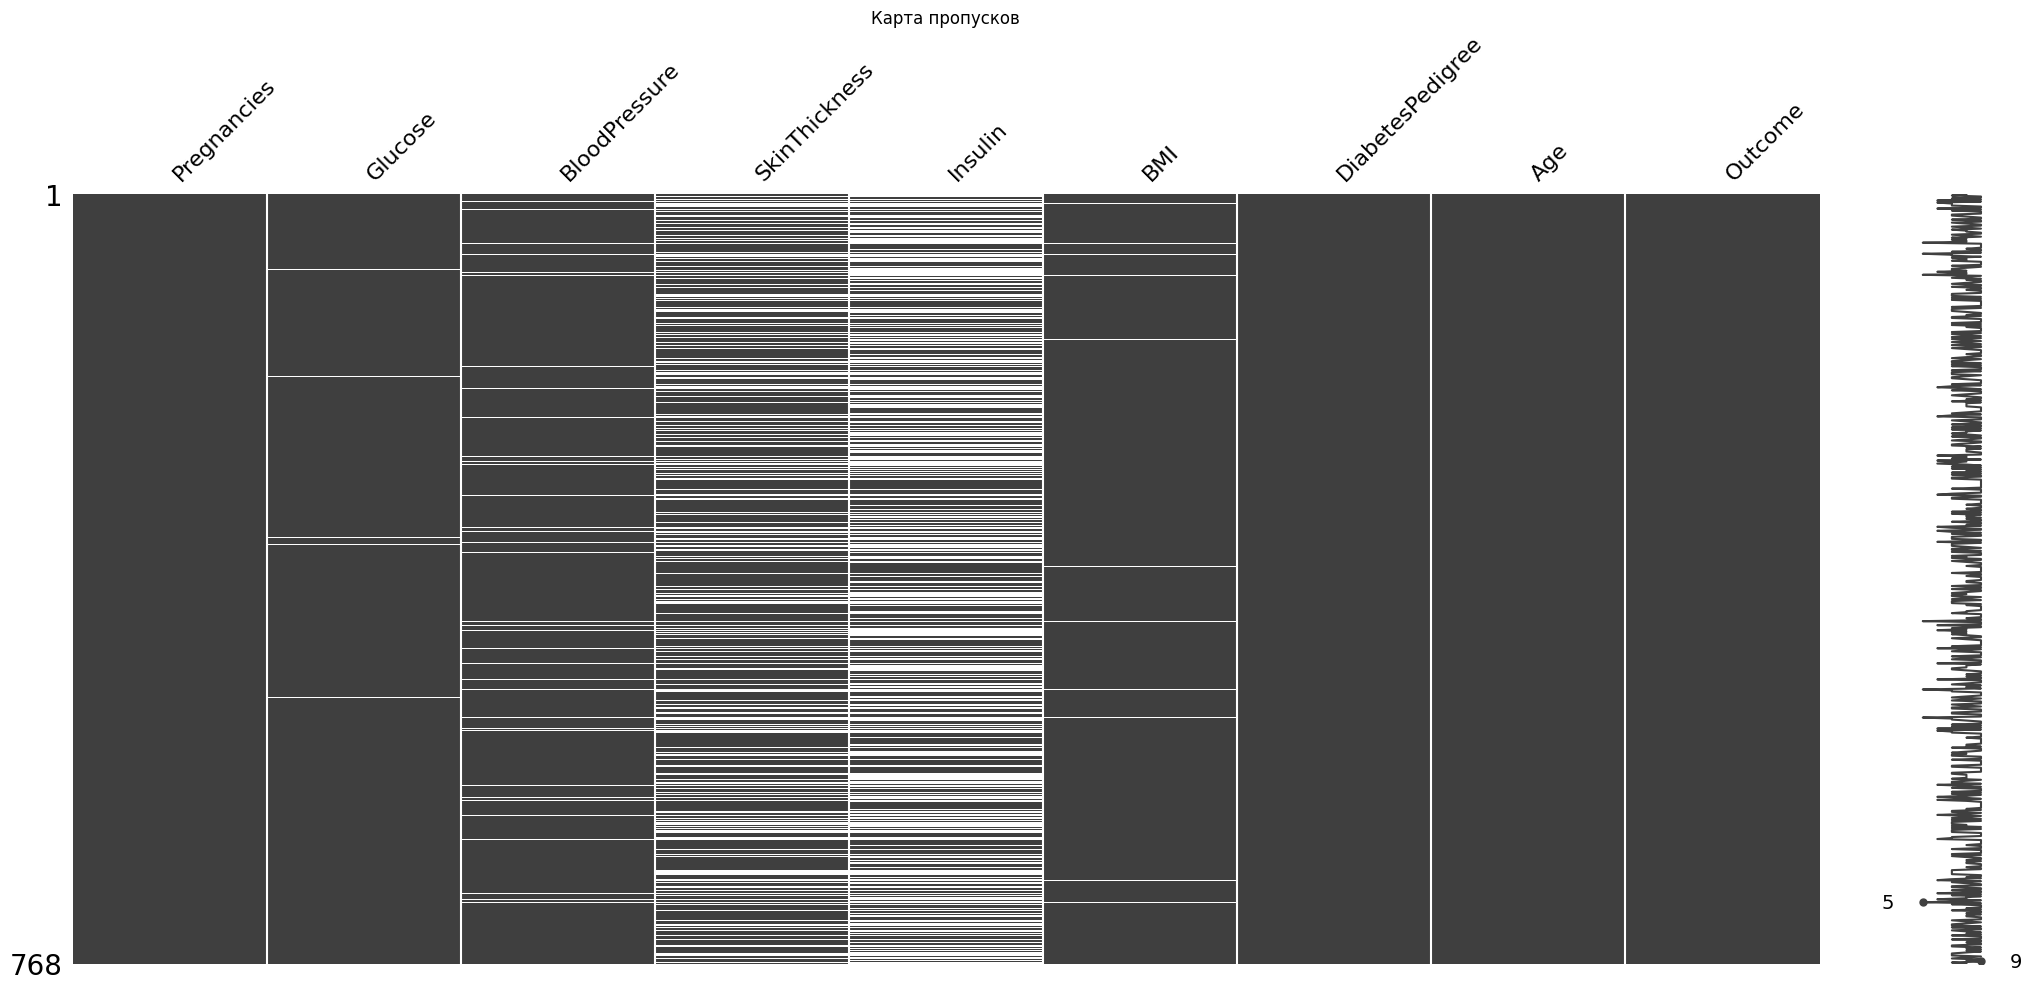

Заполнено 5 пропусков в Glucose значением 117.0
Заполнено 35 пропусков в BloodPressure значением 72.0
Заполнено 227 пропусков в SkinThickness значением 29.0
Заполнено 374 пропусков в Insulin значением 125.0
Заполнено 11 пропусков в BMI значением 32.3


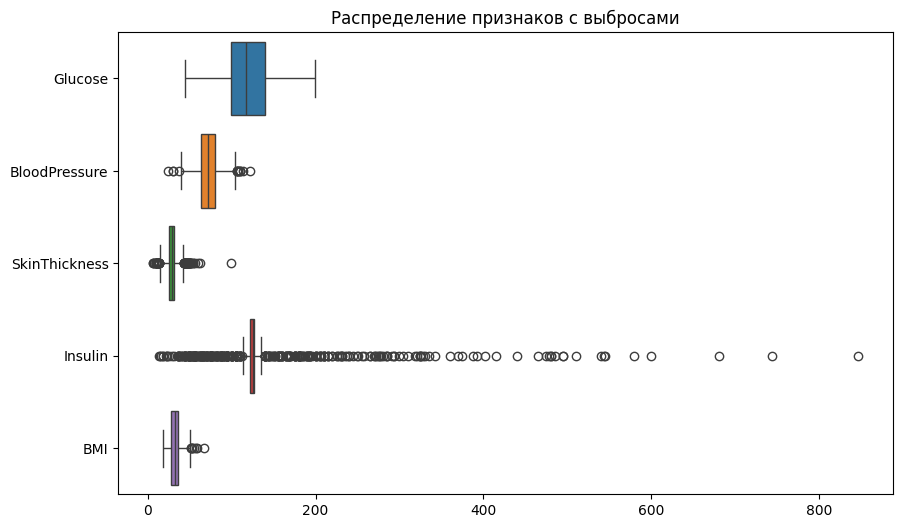

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']
df = pd.read_csv(url, names=cols)

# 1. Обнаружение пропусков (замаскированных как 0)
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)

print("Процент пропусков:")
print(df.isnull().mean().round(4) * 100)

# 2. Визуализация пропусков
import missingno as msno
msno.matrix(df)
plt.title('Карта пропусков')
plt.tight_layout()
plt.show()

# 3. Базовое заполнение пропусков
df_filled = df.copy()
for col in zero_cols:
    median_val = df[col].median()
    df_filled[col] = df[col].fillna(median_val)
    print(f"Заполнено {df[col].isnull().sum()} пропусков в {col} значением {median_val:.1f}")

# 4. Обнаружение выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filled[zero_cols], orient='h')
plt.title('Распределение признаков с выбросами')
plt.show()

#### 🟡 Продвинутый уровень: Адаптивные методы
**Теория:**  
- **Групповое заполнение**: Учет взаимосвязей между признаками  
- **KNNImputer**: Заполнение на основе похожих наблюдений  
- **Преобразование Бокса-Кокса**: Нормализация распределения

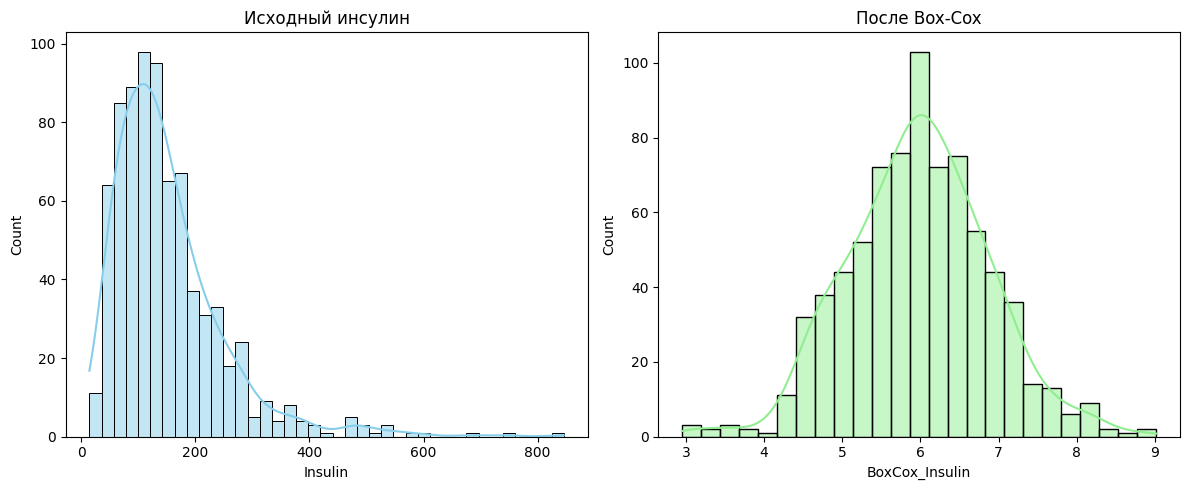

In [2]:
from sklearn.impute import KNNImputer
from scipy import stats

# Копируем данные для продвинутой обработки
df_advanced = df.copy()

# 1. Групповое заполнение глюкозы по возрасту
df_advanced['Glucose'] = df_advanced.groupby('Age')['Glucose'].transform(
    lambda x: x.fillna(x.median())
)

# 2. KNN-заполнение для остальных признаков
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(df_advanced[zero_cols])
df_advanced[zero_cols] = pd.DataFrame(imputed_data, columns=zero_cols)

# 3. Обработка выбросов через преобразование Бокса-Кокса
df_advanced['BoxCox_Insulin'], _ = stats.boxcox(df_advanced['Insulin'] + 1e-6)

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_advanced['Insulin'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Исходный инсулин')
sns.histplot(df_advanced['BoxCox_Insulin'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('После Box-Cox')
plt.tight_layout()
plt.show()

# 4. Ограничение выбросов с помощью квантилей
def cap_outliers(series, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)

for col in zero_cols:
    df_advanced[col] = cap_outliers(df_advanced[col])

#### 🔴 Экспертный уровень: Продвинутые техники
**Теория:**  
- **MICE (Multiple Imputation)**: Итеративное заполнение с учетом зависимостей  
- **Изоляционный лес**: Алгоритм ML для обнаружения аномалий  
- **Пайплайны**: Автоматизация обработки для новых данных

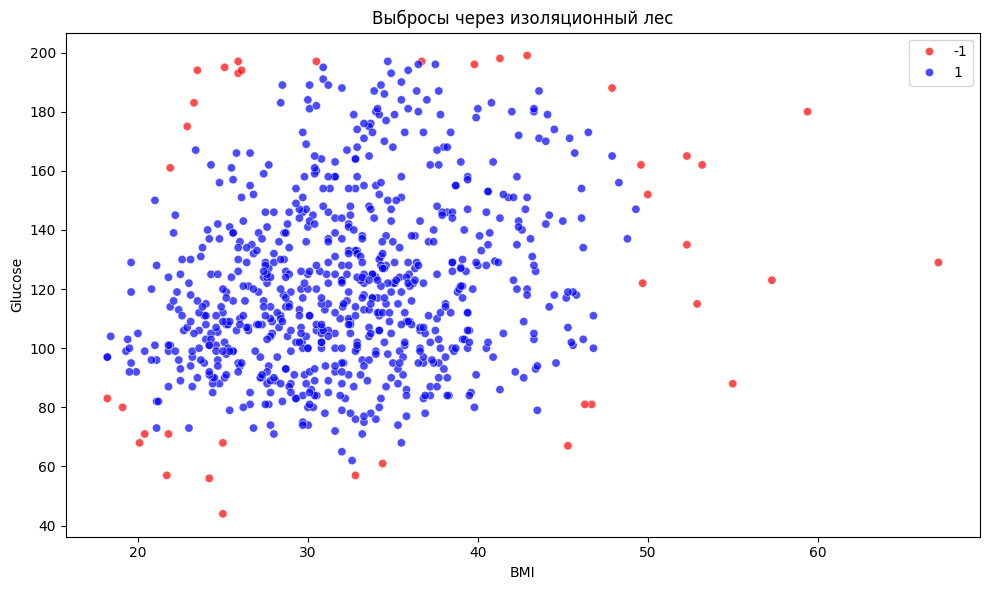

Пайплайн сохранен как 'data_pipeline.pkl'


In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

# 1. MICE-заполнение
mice_imputer = IterativeImputer(max_iter=20, random_state=42)
df_mice = df.copy()
df_mice[zero_cols] = mice_imputer.fit_transform(df_mice[zero_cols])

# 2. Обнаружение выбросов через изоляционный лес
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_mice[['BMI', 'Glucose']])
df_mice['outlier_score'] = iso_forest.decision_function(df_mice[['BMI', 'Glucose']])

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mice, x='BMI', y='Glucose', hue=outliers,
                palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title('Выбросы через изоляционный лес')
plt.tight_layout()
plt.show()

# 3. Создание пайплайна
def boxcox_transform(X):
    X = X.copy()
    for col in ['Insulin', 'SkinThickness']:
        if col in X.columns:
            X[col], _ = stats.boxcox(X[col] + 1e-6)
    return X

preprocessing_pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('boxcox', FunctionTransformer(boxcox_transform)),
    ('outlier_detector', IsolationForest(contamination=0.05, random_state=42))
])

# Сохранение пайплайна
joblib.dump(preprocessing_pipeline, 'data_pipeline.pkl')
print("Пайплайн сохранен как 'data_pipeline.pkl'")

### Сравнение методов заполнения пропусков
| Метод          | Скорость | Точность | Сохранение распределения | Сложность |
|----------------|----------|----------|---------------------------|-----------|
| **Медиана**    | ★★★      | ★★       | ★★                        | Низкая    |
| **KNNImputer** | ★★       | ★★★      | ★★★                       | Средняя   |
| **MICE**       | ★        | ★★★★     | ★★★★                      | Высокая   |

### Правила обработки выбросов
1. **Не удаляйте без анализа**: Выбросы могут содержать ценную информацию
2. **Рассмотрите преобразования**:
   - Логарифмирование: `np.log1p()`
   - Бокса-Кокса: `scipy.stats.boxcox()`
   - Квантильное отображение
3. **Сегментируйте данные**: Обрабатывайте выбросы отдельно в подгруппах

In [4]:
# Пример безопасного ограничения выбросов
def cap_outliers(series, lower_quantile=0.05, upper_quantile=0.95):
    """Ограничивает значения по заданным квантилям"""
    q_low = series.quantile(lower_quantile)
    q_high = series.quantile(upper_quantile)
    return series.clip(q_low, q_high)

# Применение функции к нескольким столбцам
for col in ['Insulin', 'SkinThickness', 'BMI']:
    df[col] = cap_outliers(df[col])

### Чеклист обработки данных
1. **Анализ пропусков**:
   - Определите природу пропусков (MCAR, MAR, MNAR)
   - Визуализируйте паттерны пропусков (`missingno`)
   
2. **Заполнение пропусков**:
   - Простые случаи: `fillna()` с медианой/модой
   - Сложные случаи: KNNImputer или MICE
   
3. **Работа с выбросами**:
   - Визуализация через boxplot и scatter plot
   - Статистические методы: z-score, IQR
   - ML-методы: изоляционный лес, DBSCAN

4. **Валидация**:
   - Сравнение распределений до/после
   - Проверка влияния на качество модели
   - Тестирование на искусственных пропусках

### Золотые правила
1. **Не доверяйте нулям** в непрерывных признаках - проверяйте на пропуски  
2. **Всегда сохраняйте исходные данные** перед обработкой  
3. **Документируйте все преобразования** - воспроизводимость критична  
4. **Тестируйте влияние очистки** на конечную метрику модели

In [5]:
# Пример воспроизводимого пайплайна
def data_cleaning_pipeline(df):
    """Автоматизированный пайплайн очистки данных"""
    df = df.copy()

    # Шаг 1: Обработка пропусков
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[zero_cols] = df[zero_cols].replace(0, np.nan)

    # Шаг 2: Заполнение
    imputer = IterativeImputer(max_iter=10, random_state=42)
    df[zero_cols] = imputer.fit_transform(df[zero_cols])

    # Шаг 3: Обработка выбросов
    for col in zero_cols:
        df[col] = cap_outliers(df[col])

    # Шаг 4: Логирование
    print(f"Обработано пропусков: {df.isnull().sum().sum()}")
    return df

# Применение пайплайна
cleaned_df = data_cleaning_pipeline(df)

Обработано пропусков: 0
